In [1]:
import os
import torch
import cv2
import cPickle
import numpy as np

from faster_rcnn import network
from faster_rcnn.faster_rcnn import FasterRCNN, RPN
from faster_rcnn.utils.timer import Timer
from faster_rcnn.fast_rcnn.nms_wrapper import nms

from faster_rcnn.fast_rcnn.bbox_transform import bbox_transform_inv, clip_boxes
from faster_rcnn.datasets.factory import get_imdb
from faster_rcnn.fast_rcnn.config import cfg, cfg_from_file, get_output_dir

from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 300


# hyper-parameters
# ------------
imdb_name = 'voc_2007_test'
#imdb_name = 'kittivoc_train'
cfg_file = 'experiments/cfgs/faster_rcnn_end2end.yml'
trained_model = '/media/data/kitti_dataset/faster_rcnn_pytorch_trained/models/saved_model3/faster_rcnn_90000.h5'
# trained_model = 'models/saved_model4/faster_rcnn_90000.h5'

rand_seed = 1024

save_name = 'faster_rcnn_100000'
max_per_image = 300
thresh = 0.05
vis = True

# ------------

if rand_seed is not None:
    np.random.seed(rand_seed)

if rand_seed is not None:
    np.random.seed(rand_seed)

# load config
cfg_from_file(cfg_file)


def vis_detections(im, class_name, dets, thresh=0.8):
    """Visual debugging of detections."""
    for i in range(np.minimum(10, dets.shape[0])):
        bbox = tuple(int(np.round(x)) for x in dets[i, :4])
        score = dets[i, -1]
        if score > thresh:
            cv2.rectangle(im, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
            cv2.putText(im, '%s: %.3f' % (class_name, score), (bbox[0], bbox[1] + 15), cv2.FONT_HERSHEY_PLAIN,
                        1.0, (0, 0, 255), thickness=1)
    return im


def im_detect(net, image):
    """Detect object classes in an image given object proposals.
    Returns:
        scores (ndarray): R x K array of object class scores (K includes
            background as object category 0)
        boxes (ndarray): R x (4*K) array of predicted bounding boxes
    """

    im_data, im_scales = net.get_image_blob(image)
    im_info = np.array(
        [[im_data.shape[1], im_data.shape[2], im_scales[0]]],
        dtype=np.float32)

    cls_prob, bbox_pred, rois = net(im_data, im_info)
    scores = cls_prob.data.cpu().numpy()
    boxes = rois.data.cpu().numpy()[:, 1:5] / im_info[0][2]

    if cfg.TEST.BBOX_REG:
        # Apply bounding-box regression deltas
        box_deltas = bbox_pred.data.cpu().numpy()
        pred_boxes = bbox_transform_inv(boxes, box_deltas)
        pred_boxes = clip_boxes(pred_boxes, image.shape)
    else:
        # Simply repeat the boxes, once for each class
        pred_boxes = np.tile(boxes, (1, scores.shape[1]))

    return scores, pred_boxes


def test_net(name, net, imdb, idx_image, max_per_image=300, thresh=0.05, vis=False):
    """Test a Fast R-CNN network on an image database."""
    num_images = len(imdb.image_index)
    # all detections are collected into:
    #    all_boxes[cls][image] = N x 5 array of detections in
    #    (x1, y1, x2, y2, score)
    all_boxes = [[[] for _ in xrange(num_images)]
                 for _ in xrange(imdb.num_classes)]

    output_dir = get_output_dir(imdb, name)

    # timers
    _t = {'im_detect': Timer(), 'misc': Timer()}
    det_file = os.path.join(output_dir, 'detections.pkl')
    
    print "# of images: ", num_images

    # for i in range(num_images):
    for i in range(idx_image,idx_image+1):

        im = cv2.imread(imdb.image_path_at(i))
        _t['im_detect'].tic()
        scores, boxes = im_detect(net, im)
        detect_time = _t['im_detect'].toc(average=False)

        _t['misc'].tic()
        if vis:
            # im2show = np.copy(im[:, :, (2, 1, 0)])
            im2show = np.copy(im)

        # skip j = 0, because it's the background class
        for j in xrange(1, imdb.num_classes):
            inds = np.where(scores[:, j] > thresh)[0]
            cls_scores = scores[inds, j]
            cls_boxes = boxes[inds, j * 4:(j + 1) * 4]
            cls_dets = np.hstack((cls_boxes, cls_scores[:, np.newaxis])) \
                .astype(np.float32, copy=False)
            keep = nms(cls_dets, cfg.TEST.NMS)
            cls_dets = cls_dets[keep, :]
            if vis:
                im2show = vis_detections(im2show, imdb.classes[j], cls_dets)
            all_boxes[j][i] = cls_dets

        # Limit to max_per_image detections *over all classes*
        if max_per_image > 0:
            image_scores = np.hstack([all_boxes[j][i][:, -1]
                                      for j in xrange(1, imdb.num_classes)])
            if len(image_scores) > max_per_image:
                image_thresh = np.sort(image_scores)[-max_per_image]
                for j in xrange(1, imdb.num_classes):
                    keep = np.where(all_boxes[j][i][:, -1] >= image_thresh)[0]
                    all_boxes[j][i] = all_boxes[j][i][keep, :]
        nms_time = _t['misc'].toc(average=False)

        print 'im_detect: {:d}/{:d} {:.3f}s {:.3f}s' \
            .format(i + 1, num_images, detect_time, nms_time)

        if vis:
            #cv2.imshow('test', im2show)
            #cv2.waitKey(0)
            plt.imshow(im2show)
    '''
    with open(det_file, 'wb') as f:
        cPickle.dump(all_boxes, f, cPickle.HIGHEST_PROTOCOL)

    print 'Evaluating detections'
    imdb.evaluate_detections(all_boxes, output_dir)
    '''

In [2]:
# load data
imdb = get_imdb(imdb_name)
imdb.competition_mode(on=True)

# load net
net = FasterRCNN(classes=imdb.classes, debug=False)
network.load_net(trained_model, net)
print('load model successfully!')

net.cuda()
net.eval()

<bound method pascal_voc.default_roidb of <faster_rcnn.datasets.pascal_voc.pascal_voc object at 0x7fb50c3203d0>>
load model successfully!


FasterRCNN(
  (rpn): RPN(
    (features): VGG16(
      (conv1): Sequential(
        (0): Conv2d(
          (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace)
        )
        (1): Conv2d(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace)
        )
        (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      )
      (conv2): Sequential(
        (0): Conv2d(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace)
        )
        (1): Conv2d(
          (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (relu): ReLU(inplace)
        )
        (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
      )
      (conv3): Sequential(
        (0): Conv2d(
          (conv): Conv2d(128, 256, kernel_size=(3, 3), stri

# of images:  4952
im_detect: 2541/4952 0.096s 0.002s


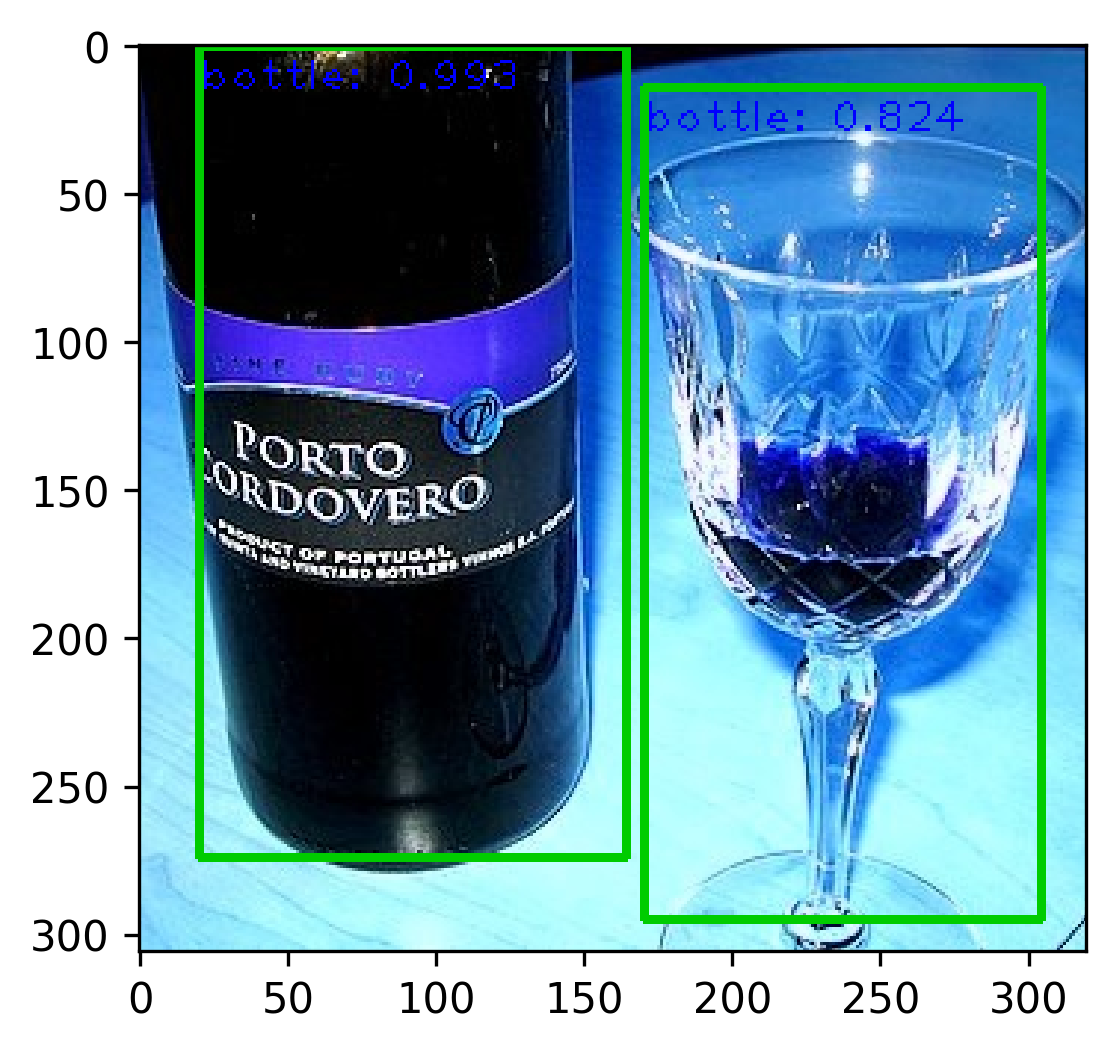

In [21]:
# evaluation
test_net(save_name, net, imdb, 2540, max_per_image, vis=True)